# Covid-19 Analysis

Looking at the Covid-19 data obtained from 'Our World in Data'.

**Index:**

- Extracting Data
    - Python imports
    - Fetch COVID-19 data from Our World in Data
    - Scrape Canadian specific data from www.canada.ca
- Filtering and Cleaning
    - Extract world record
    - Filtering for the latest data
    - Preparing population data
        -  Missing population data
    - Appending inferred information
    - Preparing Canadian specific data
- Analysis
    - World record
        - Plots
        - Table
    - Top 5: total cases per capita and deaths per total
        - Plots
        - Tables
    - Comparison between select countries
    - Highest number of total cases and deaths
        - Plots
        - Tables
    - Canadian provinces and territories
        - Canadian provinces and territories
        - Cases and Deaths
            - Plots
            - Tables
                - Total
                - Sorted by confirmed cases
        - Per Capita
            - Plots
            - Tables
                - Sorted by confirmed cases per capita
                - Population

## Extracting coronavirus and country data

### Python Imports

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

from scrape_covid19_data import DataScraper

### Fetch COVID-19 data from Our World in Data

In [ ]:
r = requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

In [ ]:
with open('full_data.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Scrape Canadian specific data from www.canada.ca

In [2]:
url = "https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html"
scraper = DataScraper(url)

### Load data 

In [133]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 

In [134]:
scraper.parse(in_memory = False)

In [135]:
rdata.tail(n = 2)

,date,location,new_cases,new_deaths,total_cases,total_deaths
7211,2020-03-26,Zimbabwe,1,0,3,1
7212,2020-03-27,Zimbabwe,0,0,3,1


In [136]:
rpopulation_data.head(n = 2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN


In [137]:
canadian_data, pub_date = scraper.get_parsed_data()

In [138]:
canadian_population_dict = {'Population':[14711827, 8537674, 5110917, 4413146, 1377517, 1181666, 977457, 779993, 521365, 158158, 44904, 39097, 41078], 
                            'Location':['Ontario', 'Quebec', 'British Columbia', 'Alberta','Manitoba','Saskatchewan',
                                        'Nova Scotia', 'New Brunswick', 'Newfoundland and Labrador','Prince Edward Island', 'Northwest Territories','Nunavut','Yukon']}

canadian_population = pd.DataFrame.from_dict(canadian_population_dict)

## Filtering and cleaning data 

In [ ]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

In [139]:
rdata = rdata.fillna(value = 0)
pdata = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
pdata.dtypes

date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object

In [140]:
rdata['date_fm'] = pd.to_datetime(rdata['date'], infer_datetime_format='%Y-%m-%d')

In [141]:
latest = pdata['date'].max()
latest

'2020-03-27'

### Extract world record

In [142]:
world_record = rdata[rdata['location'] == 'World']

In [143]:
world_record = world_record.drop(columns = ['date'])
world_record = world_record.set_index('date_fm')

### Filtering for the latest data

In [144]:
data = pdata[pdata['date'] == latest]
data = data.drop('date', axis = 1)
data = data.set_index('location')

In [145]:
data = data[data.index != 'World']

In [146]:
max_total_cases = data['total_cases'].max()

### Preparing population data

In [147]:
population = rpopulation_data.filter(['Country Name', '2018'])

In [148]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')
population.head(n=1)

,2018
location,
Aruba,105845.0


#### Missing population data

In [149]:
data[data.index.isin(population.index) == False]

,new_cases,new_deaths,total_cases,total_deaths
location,,,,
Anguilla,2,0,2,0
Guernsey,4,0,34,0
Jersey,14,1,32,1
Montserrat,4,0,5,0
Palestine,22,1,84,1
Saint Kitts and Nevis,0,0,2,0
Taiwan,17,0,252,2
Vatican,4,0,5,0


### Appending inferred information 

In [150]:
data['total_cases_per_capita'] = data['total_cases'].div(data.index.map(population['2018']))
data['total_deaths_per_capita'] = data['total_deaths'].div(data.index.map(population['2018']))
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Afghanistan,0,0,75,1,2.017627e-06,2.690169e-08,0.0133
Albania,28,1,174,6,6.070383e-05,2.093236e-06,0.0345
Algeria,41,4,305,21,7.222622e-06,4.972953e-07,0.0689
Andorra,36,3,224,3,2.908864e-03,3.895800e-05,0.0134
Angola,1,0,3,0,9.737174e-08,0.000000e+00,0.0000


### Preparing Canadian specific data

In [151]:
canadian_data = canadian_data.rename(columns = {'Number of confirmed cases': 'Confirmed Cases', 
                                                'Number of probable cases':'Probable Cases',
                                                'Number of deaths': 'Deaths',
                                                'Province, territory or other':'Location'})

In [152]:
canadian_data.set_index('Location', inplace = True)
canadian_population.set_index('Location', inplace = True)

In [153]:
canadian_data_total = canadian_data[canadian_data.index == 'Total']

In [154]:
canadian_data = canadian_data[canadian_data.index.isin(canadian_population.index) == True]
canadian_population = canadian_population[canadian_population.index.isin(canadian_data.index) == True]

In [155]:
canadian_data['Deaths per Confirmed Cases'] = (canadian_data['Deaths'].div(canadian_data['Confirmed Cases']))

In [156]:
canadian_data = canadian_data.assign(Confirmed_Cases_Per_Capita = canadian_data['Confirmed Cases'].div(canadian_population['Population']))
canadian_data = canadian_data.assign(Deaths_Per_Capita = canadian_data['Deaths'].div(canadian_population['Population']))

In [157]:
canadian_data.rename(columns = {'Confirmed_Cases_Per_Capita':'Confirmed Cases Per Capita', 
                                'Deaths_Per_Capita':'Deaths Per Capita'}, inplace = True)

## Analysis

### World record

#### Plots

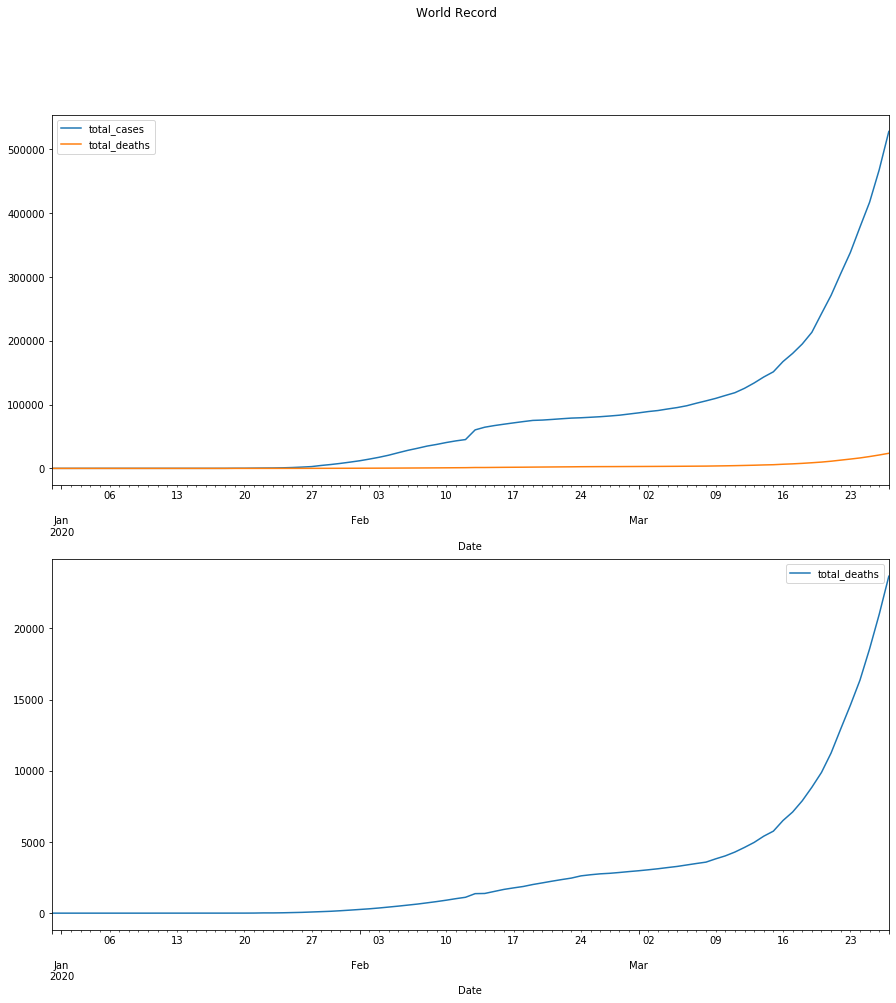

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))

fig.suptitle('World Record')

world_record.index.name = 'Date'

world_record.plot(kind='line', y= ['total_cases', 'total_deaths'], ax = ax1)
world_record.plot(kind='line', y= 'total_deaths', ax = ax2)

plt.savefig('world.png', bbox_inches = 'tight')

#### Table

In [159]:
world_record[world_record.index == latest]

,location,new_cases,new_deaths,total_cases,total_deaths
Date,,,,,
2020-03-27,World,60096,2681,528025,23669


### Top 5: total cases per capita and deaths per total

In [162]:
highest_total_cases_pc = data.nlargest(5, 'total_cases_per_capita')

In [164]:
highest_total_cases_pc = highest_total_cases_pc.merge(population, on = 'location')

In [165]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases = deaths_per_cases.merge(population, on = 'location')

In [166]:
total_cases_for_table = highest_total_cases_pc.drop(columns = ['total_deaths_per_capita', 'deaths_per_total', 'new_deaths', 'total_deaths'])
total_cases_for_table = total_cases_for_table.reset_index()
total_cases_for_table = total_cases_for_table.rename(columns = {'2018':'population'})

In [167]:
deathsratio_for_table = deaths_per_cases.drop(columns = ['new_cases', 'new_deaths', 'total_cases_per_capita', 'total_deaths_per_capita'])
deathsratio_for_table = deathsratio_for_table.reset_index()
deathsratio_for_table = deathsratio_for_table.rename(columns = {'2018':'population'})

#### Plots

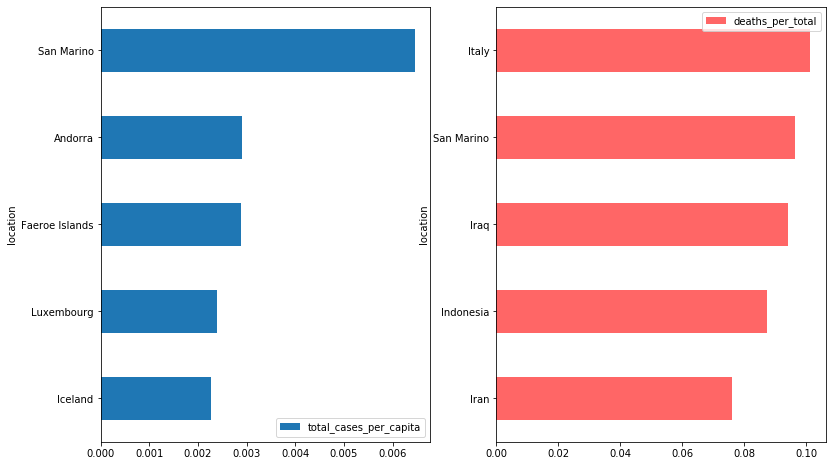

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
highest_total_cases_pc.sort_values(by = 'total_cases_per_capita', ascending = True).plot(kind='barh',y = 'total_cases_per_capita', ax = ax1,
                            ylim = (0, data['total_cases_per_capita'].max()+ 0.0005))

deaths_per_cases.sort_values(by = 'deaths_per_total', ascending = True).plot.barh(y = 'deaths_per_total', 
                                                      color ='red', ax = ax2,
                                                      alpha = 0.6)
plt.savefig('total_cases_per_capita_and_deaths_per_total.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases per capita

In [169]:
total_cases_for_table

,location,new_cases,total_cases,total_cases_per_capita,population
0,San Marino,10,218,0.006453,33785.0
1,Andorra,36,224,0.002909,77006.0
2,Faeroe Islands,8,140,0.002887,48497.0
3,Luxembourg,120,1453,0.002391,607728.0
4,Iceland,65,802,0.002268,353574.0


##### Highest deaths to total cases

In [170]:
deathsratio_for_table

,location,total_cases,total_deaths,deaths_per_total,population
0,Italy,80539,8165,0.1014,60431283.0
1,San Marino,218,21,0.0963,33785.0
2,Iraq,382,36,0.0942,38433600.0
3,Indonesia,893,78,0.0873,267663435.0
4,Iran,29406,2234,0.0760,81800269.0


### Comparison between select countries

In [175]:
filter_countries = ['Canada','United States', 'Pakistan', 'China', 'Italy']

In [176]:
earliest = '2020-03-01'
country_subset = rdata[rdata['location'].isin(filter_countries) & rdata['date_fm'].between(earliest, latest)]
country_subset = country_subset.drop(columns = ['date'])
country_subset = country_subset.set_index('date_fm')
country_subset.index.name = 'Date'

In [177]:
percapita = pd.DataFrame(country_subset['location'])
percapita['new_cases_per_capita'] =  country_subset['new_cases'].div(country_subset['location'].map(population['2018']))

In [178]:
percapita_total = pd.DataFrame(country_subset['location'])
percapita_total['total_cases_per_capita'] =  country_subset['total_cases'].div(country_subset['location'].map(population['2018']))

#### Plots

##### By new cases

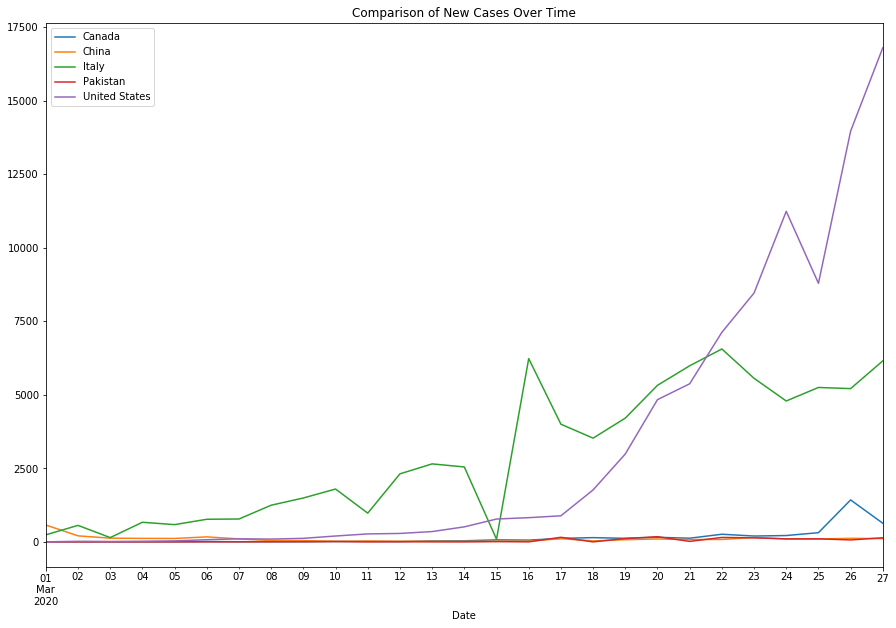

In [179]:
_, ax = plt.subplots(figsize = (15, 10))
ax.set_title('Comparison of New Cases Over Time')

for name, group in country_subset.groupby('location'):
    group.plot(kind ='line', y = 'new_cases', ax = ax, label = name)

plt.savefig('select_countries_new_cases.png', bbox_inches = 'tight')

##### New cases per capita

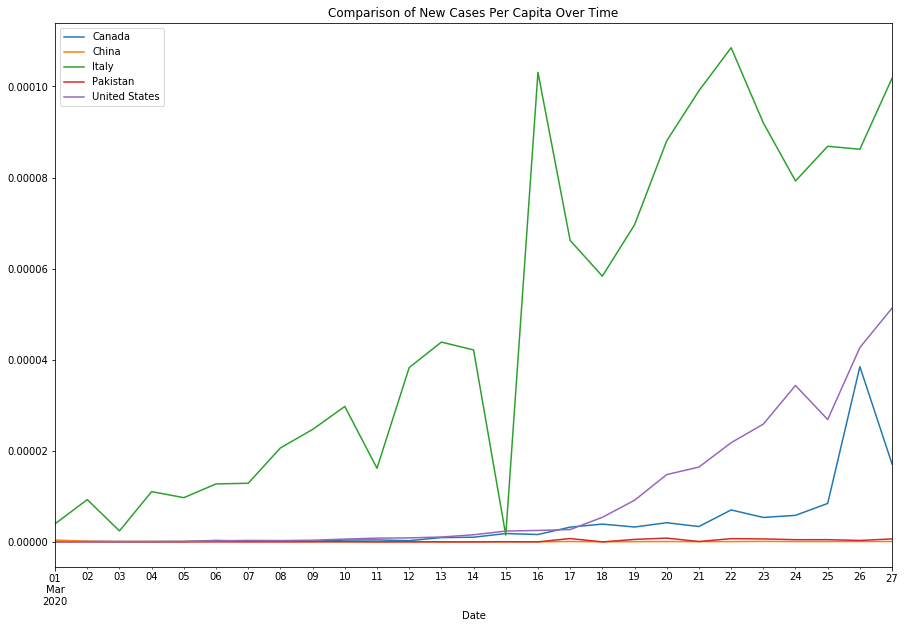

In [180]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of New Cases Per Capita Over Time')

for name, group in percapita.groupby('location'):
    group.plot(kind ='line', y = 'new_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_new_cases_per_capita.png', bbox_inches = 'tight')

##### Total cases per capita

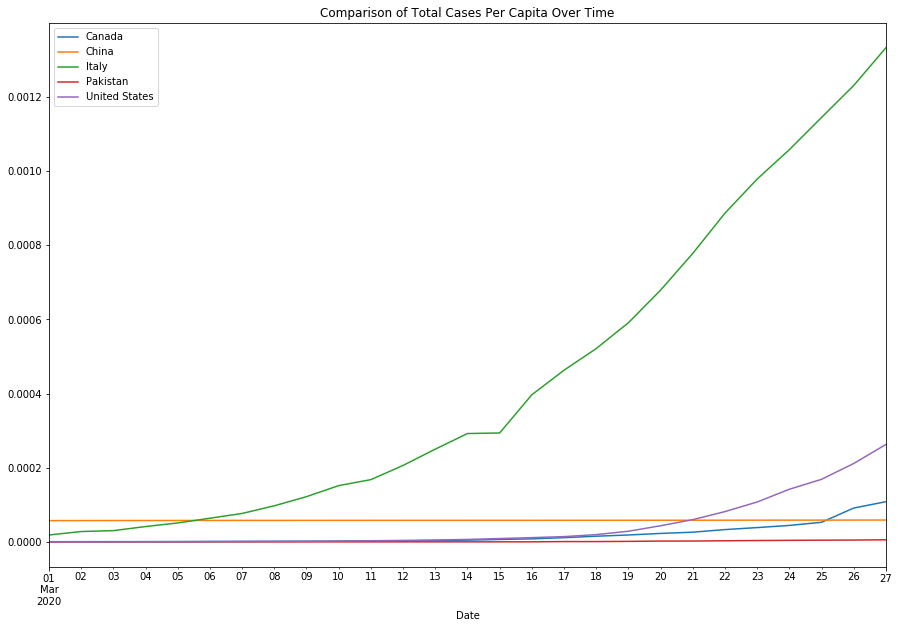

In [181]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of Total Cases Per Capita Over Time')

for name, group in percapita_total.groupby('location'):
    group.plot(kind ='line', y = 'total_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_total_cases_per_capita.png', bbox_inches = 'tight')

In [182]:
new_cases_selected_country = country_subset[country_subset['location'] == 'United States']
new_cases_selected_country.tail(n = 5)

,location,new_cases,new_deaths,total_cases,total_deaths
Date,,,,,
2020-03-23,United States,8459,131,35206,471
2020-03-24,United States,11236,119,46442,590
2020-03-25,United States,8789,211,55231,801
2020-03-26,United States,13963,249,69194,1050
2020-03-27,United States,16797,246,85991,1296


### Highest number of total cases and deaths

In [183]:
highest_total_cases = data.nlargest(5, 'total_cases')
highest_deaths = data.nlargest(5, 'total_deaths')

#### Plots

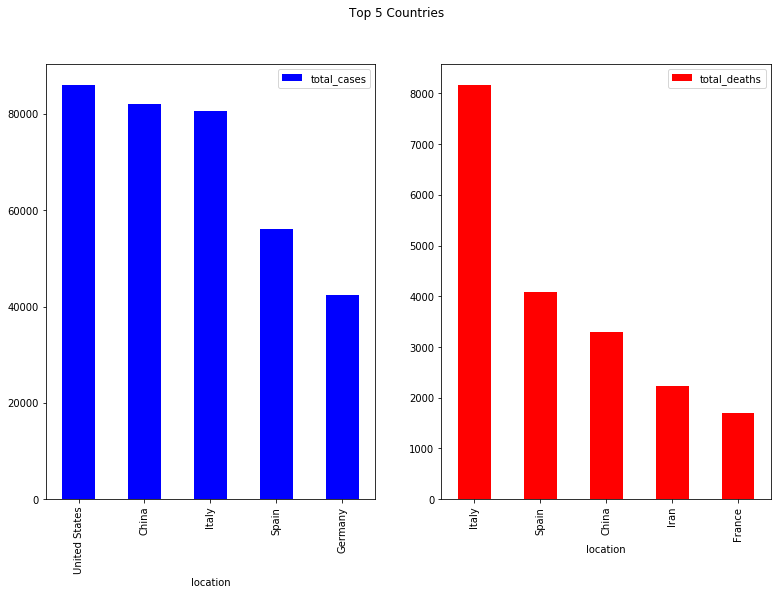

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
fig.suptitle('Top 5 Countries')

highest_total_cases.plot(kind = 'bar', y = 'total_cases', color = ['blue'], ax = ax1)
highest_deaths.plot(kind = 'bar', y = 'total_deaths', color = ['red'], ax = ax2)
plt.savefig('highest_total_cases_and_deaths.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases

In [185]:
highest_total_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
United States,16797,246,85991,1296,0.000263,0.000004,0.0151
China,111,5,82079,3298,0.000059,0.000002,0.0402
Italy,6153,660,80539,8165,0.001333,0.000135,0.1014
Spain,8578,655,56188,4089,0.001203,0.000088,0.0728
Germany,5780,55,42288,253,0.000510,0.000003,0.0060


##### Highest total deaths

In [188]:
highest_deaths

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Italy,6153,660,80539,8165,0.001333,0.000135,0.1014
Spain,8578,655,56188,4089,0.001203,0.000088,0.0728
China,111,5,82079,3298,0.000059,0.000002,0.0402
Iran,2389,157,29406,2234,0.000359,0.000027,0.0760
France,3922,365,29155,1696,0.000435,0.000025,0.0582


### Canadian provinces and territories

#### Cases and Deaths

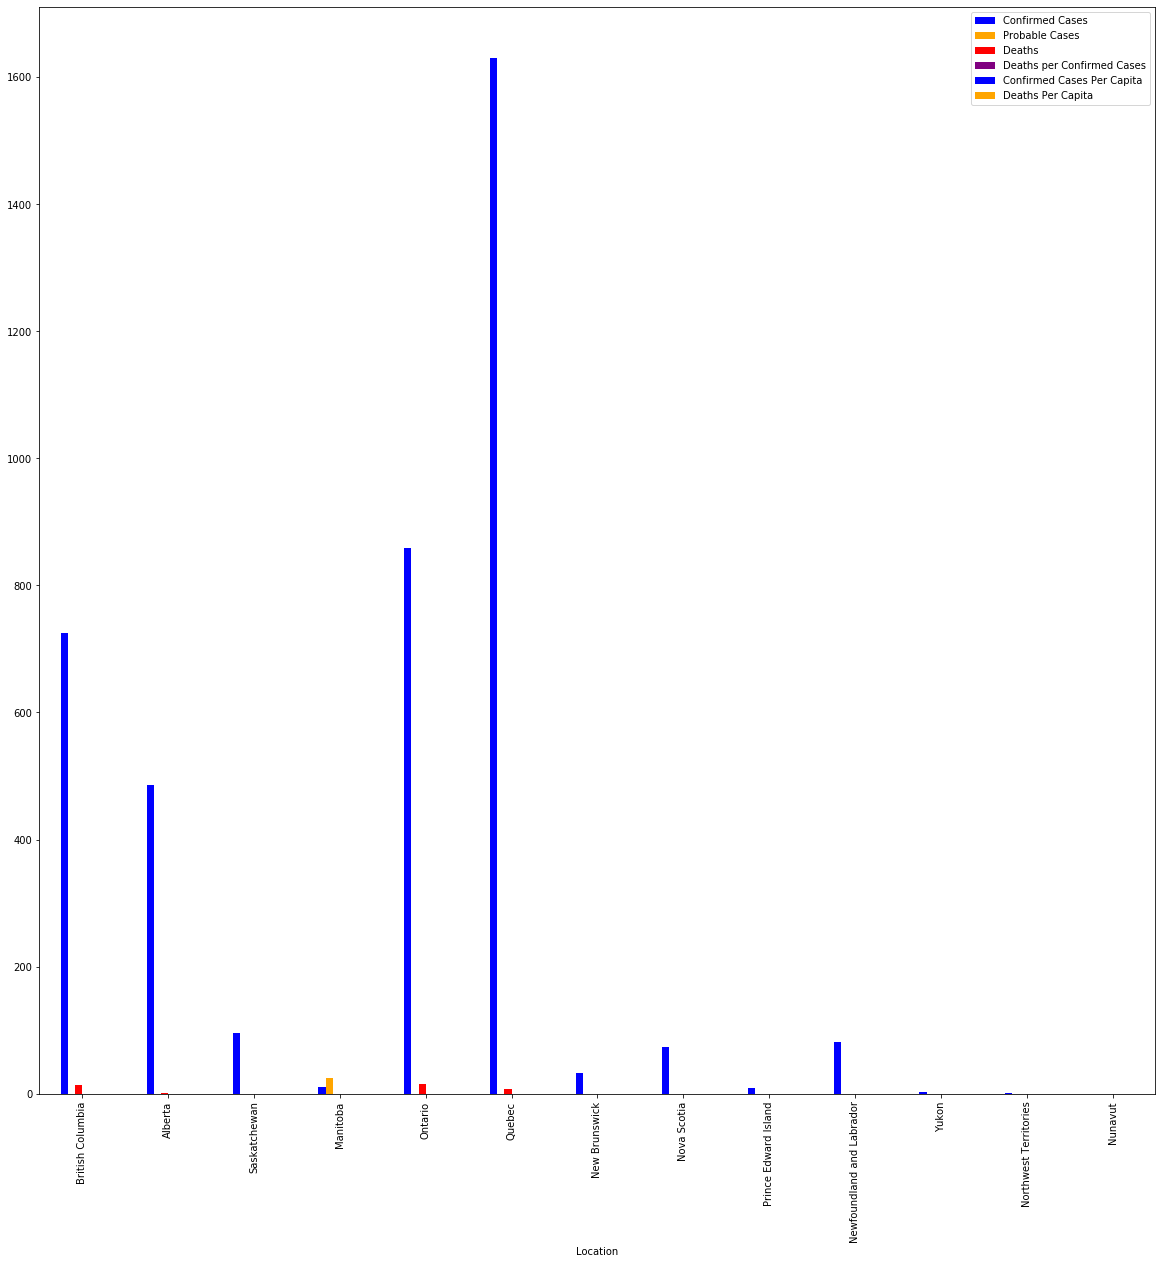

In [189]:
canadian_data.plot(kind = 'bar', color = ['blue', 'orange', 'red', 'purple'], figsize = (20,20))
plt.savefig('canadian_provinces_all.png', bbox_inches = 'tight')

In [198]:
canadian_data.sort_values(by = 'Confirmed Cases', ascending = False, inplace = True)

##### Plots

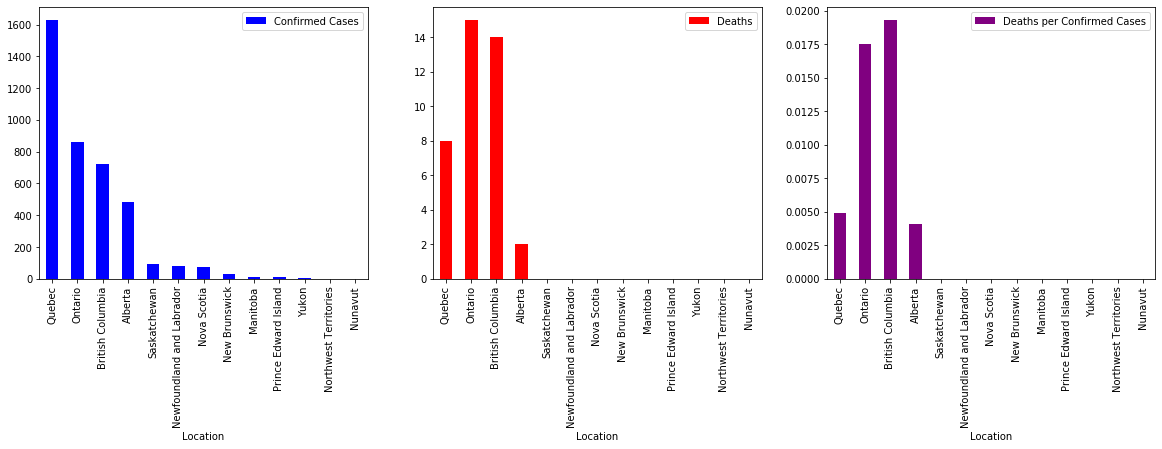

In [191]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
canadian_data.plot(kind = 'bar', y = 'Confirmed Cases', color = ['blue'], ax = ax1)
canadian_data.plot(kind = 'bar', y = 'Deaths', color = ['red'], ax = ax2)
canadian_data.plot(kind = 'bar', y = 'Deaths per Confirmed Cases', color = ['purple'], ax = ax3)
plt.savefig('canadian_provinces.png', bbox_inches = 'tight')

##### Tables

###### Total

In [192]:
canadian_data_total

,Confirmed Cases,Probable Cases,Deaths
Location,,,
Total,4018,25,39


###### Sorted by confirmed cases

In [193]:
canadian_data

,Confirmed Cases,Probable Cases,Deaths,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,
Quebec,1629,0,8,0.004911,0.000191,9.370234e-07
Ontario,858,0,15,0.017483,0.000058,1.019588e-06
British Columbia,725,0,14,0.019310,0.000142,2.739234e-06
Alberta,486,0,2,0.004115,0.000110,4.531914e-07
Saskatchewan,95,0,0,0.000000,0.000080,0.000000e+00
Newfoundland and Labrador,82,0,0,0.000000,0.000157,0.000000e+00
Nova Scotia,73,0,0,0.000000,0.000075,0.000000e+00
New Brunswick,33,0,0,0.000000,0.000042,0.000000e+00
Manitoba,11,25,0,0.000000,0.000008,0.000000e+00


#### Per Capita

##### Plots

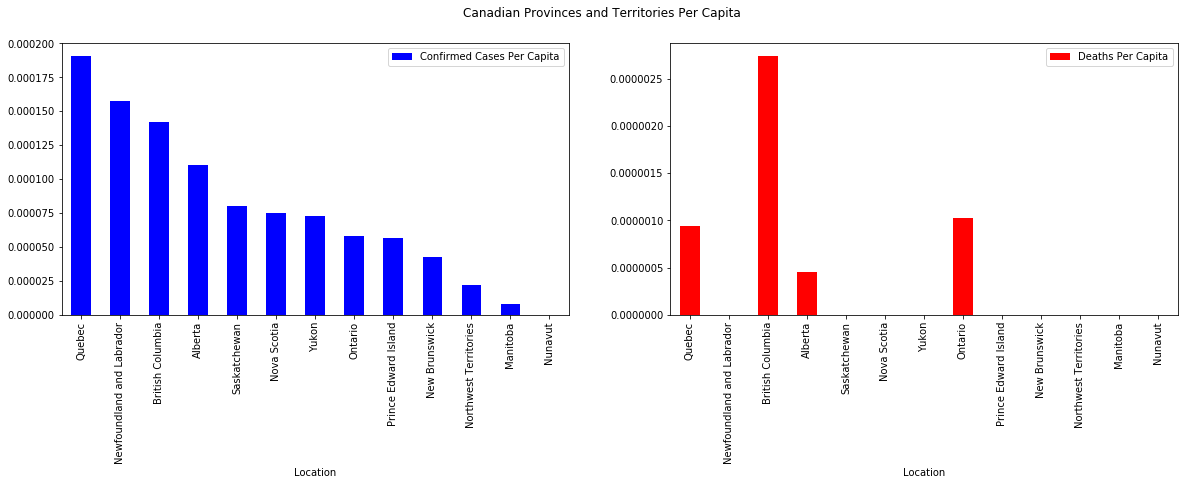

In [194]:
cdata_sorted = canadian_data.sort_values(by = 'Confirmed Cases Per Capita', ascending = False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Canadian Provinces and Territories Per Capita')

cdata_sorted.plot(kind = 'bar', y = 'Confirmed Cases Per Capita', color = ['blue'], ax = ax1)
cdata_sorted.plot(kind = 'bar', y = 'Deaths Per Capita', color = ['red'], ax = ax2)

plt.savefig('canadian_provinces_per_capita.png', bbox_inches = 'tight')

##### Tables

###### Sorted by confirmed cases per capita

In [101]:
cdata_sorted

,Confirmed Cases,Probable Cases,Deaths,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,
Quebec,1629,0,8,0.004911,0.000191,9.370234e-07
Newfoundland and Labrador,82,0,0,0.000000,0.000157,0.000000e+00
British Columbia,725,0,14,0.019310,0.000142,2.739234e-06
Alberta,486,0,2,0.004115,0.000110,4.531914e-07
Saskatchewan,95,0,0,0.000000,0.000080,0.000000e+00
Nova Scotia,73,0,0,0.000000,0.000075,0.000000e+00
Yukon,3,0,0,0.000000,0.000073,0.000000e+00
Ontario,858,0,15,0.017483,0.000058,1.019588e-06
Prince Edward Island,9,0,0,0.000000,0.000057,0.000000e+00


###### Population

In [196]:
canadian_population

,Population
Location,
Ontario,14711827
Quebec,8537674
British Columbia,5110917
Alberta,4413146
Manitoba,1377517
Saskatchewan,1181666
Nova Scotia,977457
New Brunswick,779993
Newfoundland and Labrador,521365


## Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL
3. Canadian data: https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
4. Canadian population: https://en.wikipedia.org/wiki/List_of_Canadian_provinces_and_territories_by_population